# modAL + pyhard- Comparando estratégias

- Amostra por incerteza
- Amostragem aleatória
- Consulta por comitê
- Aprendizado passivo
- Redução do erro esperado

In [1]:
%run -i set_environment

## Bibliotecas

In [39]:
%run -i importing_libraries

## Classificadores

### Algoritmos

In [26]:
%run -i classifiers

### Conjunto de dados

In [4]:
%run -i importing_datasets

## Estatratégias

### Amostra por incerteza

In [5]:
def uncertain_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
    
    from modAL.uncertainty import classifier_uncertainty
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    #initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    #X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][TRAIN][initial_idx]]
    #X_test, y_test = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    
    sample_size = sample_size + len(X_train)

    #cls = which_classifier(classifier)
    #cls.fit(X_train,y_train)

    learner = ActiveLearner (
        estimator= which_classifier(classifier), #cls,
        query_strategy=uncertainty_sampling,
        X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
    )
    
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        
        #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)
        
        idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
        X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]
        
        if classifier_uncertainty(learner, X_train[0].reshape(1,-1)) > 0.2:
            #print("IF", learner.score(X_test, y_test))
            sample_size = sample_size + len(X_train)
            learner.teach(X_train, y_train)
            uncertain_sample_score = learner.score(X_test, y_test)
            performance_history.append(uncertain_sample_score)
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw), # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Uncertain Sampling"}

### Amostragem aleatória

In [6]:
def random_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
        
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()

    for i in range(1, cost+1):

        #high = X_raw.shape[0] = qtd amostras no dataset
        #training_indices = np.random.randint(low=0, high=len(X_raw[idx_data[idx_bag][TRAIN]]), size=k+i) #high = qtd elementos na bag
        #sample_size = sample_size + len(training_indices)
        #X_train = X_raw[idx_data[idx_bag][TRAIN][training_indices]] #ASK06
        #y_train = y_raw[idx_data[idx_bag][TRAIN][training_indices]]
        #X_test = np.delete(X_raw, idx_data[idx_bag][TRAIN][training_indices], axis=0)
        #y_test = np.delete(y_raw, idx_data[idx_bag][TRAIN][training_indices], axis=0)

        X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
        sample_size = sample_size + len(X_train)
        
        cls = which_classifier(classifier)
        cls.fit(X_train, y_train)

        random_sampling_score = cls.score(X_test,y_test)
        performance_history.append(random_sampling_score)

        
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw),
             "Strategy": "Random Sampling"}

### Consulta por comitê

In [7]:
def query_by_committee(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.models import ActiveLearner, Committee
    from modAL.disagreement import vote_entropy_sampling

    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()

    learner_list = []

    for j in range(1, cost+1): # Loop para criação do comitê

        X_train, X_pool, y_train, y_pool = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
        sample_size = sample_size + len(X_train)

        # initializing learner
        learner = ActiveLearner(
            estimator= which_classifier(classifier),
            X_training = X_train, y_training = y_train 
        )
        learner_list.append(learner)

    # assembling the committee
    committee = Committee(
        learner_list=learner_list,
        query_strategy=vote_entropy_sampling)

    #X_pool, y_pool = X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]]
    
    # query by committee
    for idx in range(cost):
        print("\t Size of X_pool:", len(X_pool))
        query_idx, query_instance = committee.query(X_pool, n_instances = init_size+1)
        sample_size = sample_size + len(query_idx)
        
        committee.teach(
            X = X_pool[query_idx],
            y = y_pool[query_idx]
        )

        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)
        
        query_by_committee_score = committee.score(X_pool, y_pool)
        performance_history.append(query_by_committee_score)

        
    end = timer()
    time_elapsed = end - start

    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw),
             "Strategy": "Query by Committee"}

### Expected Error Reduction

In [8]:
def exp_error_reduction(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.expected_error import expected_error_reduction
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    #initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    #X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][TRAIN][initial_idx]]
    #X_pool, y_pool = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    X_train, X_pool, y_train, y_pool = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    sample_size = sample_size + len(X_train)

    X_pool, y_pool = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    learner = ActiveLearner (
        estimator = which_classifier(classifier),
        X_training = X_train, y_training = y_train
    )
    exp_er_score = learner.score(X_pool, y_pool)
    performance_history.append(exp_er_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        print("\t Size of X_pool:", len(X_pool))
        exp_error_idx = expected_error_reduction(learner, X_pool, 'binary', n_instances=init_size)

        learner.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        sample_size = sample_size + init_size
    
        X_pool = np.delete(X_pool, exp_error_idx, axis=0)
        y_pool = np.delete(y_pool, exp_error_idx)
        
        exp_er_score = learner.score(X_pool, y_pool)
        performance_history.append(exp_er_score)
        
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw), # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Expected Error Reduction"}

### Expected Model Change

In [24]:
def exp_model_change(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.expected_error import expected_error_reduction
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    #initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    #X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][0][initial_idx]]
    #X_pool, y_pool = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    X_train, X_pool, y_train, y_pool = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator = which_classifier(classifier),
        X_training = X_train, y_training = y_train
    )
    
#     performance_history.append(uncertain_sample_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        print("\t Size of X_pool:", len(X_pool))
        exp_error_idx = np.random.choice(range(len(X_pool)), size=init_size, replace=False)
        aux = deepcopy(learner)

        aux.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        score_aux = aux.score(X_pool, y_pool)
        score_learner = learner.score(X_pool, y_pool)

        if score_aux > score_learner:
            learner = deepcopy(aux)
            sample_size = sample_size + init_size
        
        X_pool = np.delete(X_pool, exp_error_idx, axis=0)
        y_pool = np.delete(y_pool, exp_error_idx, axis=0)
        
        exp_mo_score = learner.score(X_pool, y_pool)
        performance_history.append(exp_mo_score)

        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw), # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Expected Model Change"}

## Pyhard Strategies

In [10]:
def config(section, filename='strategies.config'):
    from configparser import ConfigParser

    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read("../" + filename)
    # get section, default to postgresql
    strategy = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            strategy[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    # transformando texto em bool
    strategy['ascending'] = list(map(lambda x: bool(0 if x == "False" else 1), strategy['ascending'].split(',')))
    strategy['sortby'] = strategy['sortby'].split(',')
    
    print(strategy)
    
    return strategy

In [11]:
def pyhard_strategies(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost, strategy):
    
    from modAL.uncertainty import classifier_uncertainty
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    strategy = config(strategy)
    
    # parte randomica inicial da estratégia
    
    X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator= which_classifier(classifier), #cls,
        query_strategy=uncertainty_sampling,
        X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
    )
    
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)

    total_of_samples = 1

    #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)

    idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]

    X_rawAndY_raw = np.column_stack([X_raw[idx_data[idx_bag][TRAIN]],y_raw[idx_data[idx_bag][TRAIN]]])
    np.savetxt("data.csv", X_rawAndY_raw, fmt='%i', delimiter=",")
    
    which_pyhard_measure(strategy['measure'])

    !pyhard --no-isa

    df = pd.read_csv('metadata.csv')

    idx = list(df.sort_values(by=strategy['sortby'], ascending=strategy['ascending'])['instances'][:cost])

    X_train = X_raw[idx_data[idx_bag][TRAIN][idx]]
    y_train = y_raw[idx_data[idx_bag][TRAIN][idx]]

    sample_size = cost
    learner.teach(X_train, y_train)
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw), # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": strategy['name']}

In [41]:
pyhard_strategies_names = ['H','U','H+U','LSC','N2','F3']

for ds in datasets:
    for classifier in classifiers:
        X_raw, y_raw, idx_data, dataset_name = which_arff_dataset(ds)
        #para cada i em idx_bag ("n_splits") (1 a 5)
        for idx_bag in range(n_splits):
            for ph_strategy in pyhard_strategies_names:
                tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " " + ph_strategy)
                result = pyhard_strategies(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost, ph_strategy)
                result['dataset'] = ds[:-5]
                total_performance_history.append(result)
                tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " " + ph_strategy)        

Testando: 61_iris 5NN 0/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:01:21,703 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:01:21,703 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-26 22:01:21,705 - Type of problem: 'classification'
[INFO] 2021-04-26 22:01:21,705 - Building metadata.
[INFO] 2021-04-26 22:01:23,608 - Calculating measure 'Harmfulness'
[INFO] 2021-04-26 22:01:23,610 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:01:23,610 - Estimating instance performance...
[INFO] 2021-04-26 22:01:23,610 - Evaluating testing fold #1
[INFO] 2021-04-26 22:01:23,772 - Test fold mean accuracy: 0.9615384615384616
[INFO] 2021-04-26 22:01:23,7

Passou: 61_iris 5NN 0/5 F3
Testando: 61_iris 5NN 1/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:01:52,732 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:01:52,732 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-26 22:01:52,735 - Type of problem: 'classification'
[INFO] 2021-04-26 22:01:52,735 - Building metadata.
[INFO] 2021-04-26 22:01:54,406 - Calculating measure 'Harmfulness'
[INFO] 2021-04-26 22:01:54,408 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:01:54,408 - Estimating instance performance...
[INFO] 2021-04-26 22:01:54,409 - Evaluating testing fold #1
[INFO] 2021-04-26 22:01:54,585 - Test fold mean accuracy: 0.9807692307692307
[

Passou: 61_iris 5NN 1/5 F3
Testando: 61_iris 5NN 2/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:02:22,404 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:02:22,404 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-26 22:02:22,407 - Type of problem: 'classification'
[INFO] 2021-04-26 22:02:22,407 - Building metadata.
[INFO] 2021-04-26 22:02:24,225 - Calculating measure 'Harmfulness'
[INFO] 2021-04-26 22:02:24,227 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:02:24,227 - Estimating instance performance...
[INFO] 2021-04-26 22:02:24,228 - Evaluating testing fold #1
[INFO] 2021-04-26 22:02:24,396 - Test fold mean accuracy: 0.9230769230769231
[

[INFO] 2021-04-26 22:02:50,479 - Instance Hardness analysis finished.
Passou: 61_iris 5NN 2/5 F3
Testando: 61_iris 5NN 3/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:02:53,329 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:02:53,330 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-26 22:02:53,332 - Type of problem: 'classification'
[INFO] 2021-04-26 22:02:53,332 - Building metadata.
[INFO] 2021-04-26 22:02:55,050 - Calculating measure 'Harmfulness'
[INFO] 2021-04-26 22:02:55,052 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:02:55,052 - Estimating instance performance...
[INFO] 2021-04-26 22:02:55,053 - Evaluating testing fold #1
[INFO] 2

Passou: 61_iris 5NN 3/5 F3
Testando: 61_iris 5NN 4/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:03:24,008 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:03:24,008 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-26 22:03:24,010 - Type of problem: 'classification'
[INFO] 2021-04-26 22:03:24,011 - Building metadata.
[INFO] 2021-04-26 22:03:25,747 - Calculating measure 'Harmfulness'
[INFO] 2021-04-26 22:03:25,748 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:03:25,748 - Estimating instance performance...
[INFO] 2021-04-26 22:03:25,749 - Evaluating testing fold #1
[INFO] 2021-04-26 22:03:25,912 - Test fold mean accuracy: 0.9423076923076923
[

Passou: 61_iris 5NN 4/5 F3
Testando: 61_iris C4.5 0/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:03:54,010 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:03:54,010 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-26 22:03:54,012 - Type of problem: 'classification'
[INFO] 2021-04-26 22:03:54,012 - Building metadata.
[INFO] 2021-04-26 22:03:55,740 - Calculating measure 'Harmfulness'
[INFO] 2021-04-26 22:03:55,742 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:03:55,742 - Estimating instance performance...
[INFO] 2021-04-26 22:03:55,742 - Evaluating testing fold #1
[INFO] 2021-04-26 22:03:55,895 - Test fold mean accuracy: 0.9615384615384616


Passou: 61_iris C4.5 0/5 F3
Testando: 61_iris C4.5 1/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:04:24,617 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:04:24,617 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-26 22:04:24,620 - Type of problem: 'classification'
[INFO] 2021-04-26 22:04:24,620 - Building metadata.
[INFO] 2021-04-26 22:04:26,631 - Calculating measure 'Harmfulness'
[INFO] 2021-04-26 22:04:26,633 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:04:26,633 - Estimating instance performance...
[INFO] 2021-04-26 22:04:26,633 - Evaluating testing fold #1
[INFO] 2021-04-26 22:04:26,803 - Test fold mean accuracy: 0.9807692307692307

Passou: 61_iris C4.5 1/5 F3
Testando: 61_iris C4.5 2/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:05:01,127 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:05:01,128 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-26 22:05:01,131 - Type of problem: 'classification'
[INFO] 2021-04-26 22:05:01,132 - Building metadata.
[INFO] 2021-04-26 22:05:04,045 - Calculating measure 'Harmfulness'
[INFO] 2021-04-26 22:05:04,048 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:05:04,048 - Estimating instance performance...
[INFO] 2021-04-26 22:05:04,049 - Evaluating testing fold #1
[INFO] 2021-04-26 22:05:04,314 - Test fold mean accuracy: 0.9230769230769231

Passou: 61_iris C4.5 2/5 F3
Testando: 61_iris C4.5 3/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:05:53,368 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:05:53,369 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-26 22:05:53,372 - Type of problem: 'classification'
[INFO] 2021-04-26 22:05:53,372 - Building metadata.
[INFO] 2021-04-26 22:05:55,850 - Calculating measure 'Harmfulness'
[INFO] 2021-04-26 22:05:55,852 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:05:55,852 - Estimating instance performance...
[INFO] 2021-04-26 22:05:55,853 - Evaluating testing fold #1
[INFO] 2021-04-26 22:05:56,077 - Test fold mean accuracy: 0.9615384615384616

[INFO] 2021-04-26 22:06:31,964 - Total elapsed time: 4.1s
[INFO] 2021-04-26 22:06:31,964 - Instance Hardness analysis finished.
Passou: 61_iris C4.5 3/5 F3
Testando: 61_iris C4.5 4/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:06:37,643 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:06:37,644 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-26 22:06:37,649 - Type of problem: 'classification'
[INFO] 2021-04-26 22:06:37,649 - Building metadata.
[INFO] 2021-04-26 22:06:41,754 - Calculating measure 'Harmfulness'
[INFO] 2021-04-26 22:06:41,758 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:06:41,758 - Estimating instance performance...
[INFO] 2

[INFO] 2021-04-26 22:07:33,860 - Test fold mean accuracy: 0.9615384615384616
[INFO] 2021-04-26 22:07:33,860 - Iteration 1/1 completed.
[INFO] 2021-04-26 22:07:33,861 - Mean accuracy on test instances (iteration #1): 0.9519
[INFO] 2021-04-26 22:07:33,875 - Total elapsed time: 3.9s
[INFO] 2021-04-26 22:07:33,875 - Instance Hardness analysis finished.
Passou: 61_iris C4.5 4/5 F3
Testando: 61_iris NB 0/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:07:38,100 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:07:38,101 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-26 22:07:38,104 - Type of problem: 'classification'
[INFO] 2021-04-26 22:07:38,104 - Building metadata.
[INFO] 

[INFO] 2021-04-26 22:08:10,805 - Test fold mean accuracy: 0.9615384615384616
[INFO] 2021-04-26 22:08:10,805 - Evaluating testing fold #2
[INFO] 2021-04-26 22:08:10,976 - Test fold mean accuracy: 0.9423076923076923
[INFO] 2021-04-26 22:08:10,976 - Iteration 1/1 completed.
[INFO] 2021-04-26 22:08:10,976 - Mean accuracy on test instances (iteration #1): 0.9519
[INFO] 2021-04-26 22:08:10,987 - Total elapsed time: 2.5s
[INFO] 2021-04-26 22:08:10,987 - Instance Hardness analysis finished.
Passou: 61_iris NB 0/5 F3
Testando: 61_iris NB 1/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:08:14,082 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-26 22:08:14,083 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/d

[INFO] 2021-04-26 22:08:44,448 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:08:44,449 - Estimating instance performance...
[INFO] 2021-04-26 22:08:44,449 - Evaluating testing fold #1
[INFO] 2021-04-26 22:08:44,649 - Test fold mean accuracy: 0.9807692307692307
[INFO] 2021-04-26 22:08:44,650 - Evaluating testing fold #2
[INFO] 2021-04-26 22:08:44,836 - Test fold mean accuracy: 0.9423076923076923
[INFO] 2021-04-26 22:08:44,836 - Iteration 1/1 completed.
[INFO] 2021-04-26 22:08:44,836 - Mean accuracy on test instances (iteration #1): 0.9615
[INFO] 2021-04-26 22:08:44,846 - Total elapsed time: 2.6s
[INFO] 2021-04-26 22:08:44,846 - Instance Hardness analysis finished.
Passou: 61_iris NB 1/5 F3
Testando: 61_iris NB 2/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:08:48,152 - Configuration file: '/Users/tiagocabral/Documents/U

[INFO] 2021-04-26 22:09:23,193 - Calculating measure 'F3'
[INFO] 2021-04-26 22:09:23,218 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:09:23,218 - Estimating instance performance...
[INFO] 2021-04-26 22:09:23,219 - Evaluating testing fold #1
[INFO] 2021-04-26 22:09:23,435 - Test fold mean accuracy: 0.9230769230769231
[INFO] 2021-04-26 22:09:23,435 - Evaluating testing fold #2
[INFO] 2021-04-26 22:09:23,635 - Test fold mean accuracy: 0.9423076923076923
[INFO] 2021-04-26 22:09:23,636 - Iteration 1/1 completed.
[INFO] 2021-04-26 22:09:23,636 - Mean accuracy on test instances (iteration #1): 0.9327
[INFO] 2021-04-26 22:09:23,646 - Total elapsed time: 2.8s
[INFO] 2021-04-26 22:09:23,646 - Instance Hardness analysis finished.
Passou: 61_iris NB 2/5 F3
Testando: 61_iris NB 3/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:09:27

[INFO] 2021-04-26 22:10:24,538 - Calculating measure 'F3'
[INFO] 2021-04-26 22:10:24,604 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:10:24,605 - Estimating instance performance...
[INFO] 2021-04-26 22:10:24,607 - Evaluating testing fold #1
[INFO] 2021-04-26 22:10:25,110 - Test fold mean accuracy: 0.9615384615384616
[INFO] 2021-04-26 22:10:25,110 - Evaluating testing fold #2
[INFO] 2021-04-26 22:10:25,521 - Test fold mean accuracy: 0.9038461538461539
[INFO] 2021-04-26 22:10:25,521 - Iteration 1/1 completed.
[INFO] 2021-04-26 22:10:25,522 - Mean accuracy on test instances (iteration #1): 0.9327
[INFO] 2021-04-26 22:10:25,545 - Total elapsed time: 6.6s
[INFO] 2021-04-26 22:10:25,545 - Instance Hardness analysis finished.
Passou: 61_iris NB 3/5 F3
Testando: 61_iris NB 4/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:10:31

[INFO] 2021-04-26 22:11:04,600 - Calculating measure 'F3'
[INFO] 2021-04-26 22:11:04,621 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:11:04,622 - Estimating instance performance...
[INFO] 2021-04-26 22:11:04,623 - Evaluating testing fold #1
[INFO] 2021-04-26 22:11:04,799 - Test fold mean accuracy: 0.9423076923076923
[INFO] 2021-04-26 22:11:04,800 - Evaluating testing fold #2
[INFO] 2021-04-26 22:11:04,972 - Test fold mean accuracy: 0.9615384615384616
[INFO] 2021-04-26 22:11:04,973 - Iteration 1/1 completed.
[INFO] 2021-04-26 22:11:04,973 - Mean accuracy on test instances (iteration #1): 0.9519
[INFO] 2021-04-26 22:11:04,981 - Total elapsed time: 2.4s
[INFO] 2021-04-26 22:11:04,981 - Instance Hardness analysis finished.
Passou: 61_iris NB 4/5 F3
Testando: 61_iris RF 0/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:11:08

[INFO] 2021-04-26 22:11:42,131 - Calculating measure 'F3'
[INFO] 2021-04-26 22:11:42,162 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:11:42,162 - Estimating instance performance...
[INFO] 2021-04-26 22:11:42,163 - Evaluating testing fold #1
[INFO] 2021-04-26 22:11:42,411 - Test fold mean accuracy: 0.9615384615384616
[INFO] 2021-04-26 22:11:42,411 - Evaluating testing fold #2
[INFO] 2021-04-26 22:11:42,645 - Test fold mean accuracy: 0.9423076923076923
[INFO] 2021-04-26 22:11:42,645 - Iteration 1/1 completed.
[INFO] 2021-04-26 22:11:42,646 - Mean accuracy on test instances (iteration #1): 0.9519
[INFO] 2021-04-26 22:11:42,657 - Total elapsed time: 3.3s
[INFO] 2021-04-26 22:11:42,657 - Instance Hardness analysis finished.
Passou: 61_iris RF 0/5 F3
Testando: 61_iris RF 1/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:11:47

[INFO] 2021-04-26 22:12:35,937 - Calculating measure 'F3'
[INFO] 2021-04-26 22:12:35,965 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:12:35,965 - Estimating instance performance...
[INFO] 2021-04-26 22:12:35,966 - Evaluating testing fold #1
[INFO] 2021-04-26 22:12:36,194 - Test fold mean accuracy: 0.9807692307692307
[INFO] 2021-04-26 22:12:36,194 - Evaluating testing fold #2
[INFO] 2021-04-26 22:12:36,416 - Test fold mean accuracy: 0.9423076923076923
[INFO] 2021-04-26 22:12:36,416 - Iteration 1/1 completed.
[INFO] 2021-04-26 22:12:36,416 - Mean accuracy on test instances (iteration #1): 0.9615
[INFO] 2021-04-26 22:12:36,426 - Total elapsed time: 3.1s
[INFO] 2021-04-26 22:12:36,426 - Instance Hardness analysis finished.
Passou: 61_iris RF 1/5 F3
Testando: 61_iris RF 2/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:12:40

[INFO] 2021-04-26 22:13:11,061 - Calculating measure 'F3'
[INFO] 2021-04-26 22:13:11,083 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:13:11,083 - Estimating instance performance...
[INFO] 2021-04-26 22:13:11,084 - Evaluating testing fold #1
[INFO] 2021-04-26 22:13:11,279 - Test fold mean accuracy: 0.9230769230769231
[INFO] 2021-04-26 22:13:11,279 - Evaluating testing fold #2
[INFO] 2021-04-26 22:13:11,458 - Test fold mean accuracy: 0.9423076923076923
[INFO] 2021-04-26 22:13:11,458 - Iteration 1/1 completed.
[INFO] 2021-04-26 22:13:11,458 - Mean accuracy on test instances (iteration #1): 0.9327
[INFO] 2021-04-26 22:13:11,466 - Total elapsed time: 2.5s
[INFO] 2021-04-26 22:13:11,467 - Instance Hardness analysis finished.
Passou: 61_iris RF 2/5 F3
Testando: 61_iris RF 3/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --help' to see all options.
[INFO] 2021-04-26 22:13:14

[INFO] 2021-04-26 22:14:03,343 - Building metadata.
[INFO] 2021-04-26 22:14:08,426 - Calculating measure 'F3'
[INFO] 2021-04-26 22:14:08,480 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:14:08,481 - Estimating instance performance...
[INFO] 2021-04-26 22:14:08,482 - Evaluating testing fold #1
[INFO] 2021-04-26 22:14:09,014 - Test fold mean accuracy: 0.9615384615384616
[INFO] 2021-04-26 22:14:09,014 - Evaluating testing fold #2
[INFO] 2021-04-26 22:14:09,476 - Test fold mean accuracy: 0.9038461538461539
[INFO] 2021-04-26 22:14:09,476 - Iteration 1/1 completed.
[INFO] 2021-04-26 22:14:09,477 - Mean accuracy on test instances (iteration #1): 0.9327
[INFO] 2021-04-26 22:14:09,499 - Total elapsed time: 6.2s
[INFO] 2021-04-26 22:14:09,499 - Instance Hardness analysis finished.
Passou: 61_iris RF 3/5 F3
Testando: 61_iris RF 4/5 H
{'name': 'Lowest Harmfulness Sampling', 'measure': 'Harmfulness', 'sortby': ['feature_Harmfulness'], 'ascending': [True]}
run 'pyhard --

[INFO] 2021-04-26 22:15:08,967 - Calculating measure 'F3'
[INFO] 2021-04-26 22:15:08,990 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-26 22:15:08,990 - Estimating instance performance...
[INFO] 2021-04-26 22:15:08,991 - Evaluating testing fold #1
[INFO] 2021-04-26 22:15:09,181 - Test fold mean accuracy: 0.9423076923076923
[INFO] 2021-04-26 22:15:09,181 - Evaluating testing fold #2
[INFO] 2021-04-26 22:15:09,369 - Test fold mean accuracy: 0.9615384615384616
[INFO] 2021-04-26 22:15:09,369 - Iteration 1/1 completed.
[INFO] 2021-04-26 22:15:09,370 - Mean accuracy on test instances (iteration #1): 0.9519
[INFO] 2021-04-26 22:15:09,379 - Total elapsed time: 2.5s
[INFO] 2021-04-26 22:15:09,379 - Instance Hardness analysis finished.
Passou: 61_iris RF 4/5 F3


## Setup

In [13]:
def which_pyhard_measure(measure='LSC'):
    import yaml
    with open(r'config-template.yaml') as file:
        configs_list = yaml.load(file, Loader=yaml.FullLoader)

        if measure == 'LSC':
            configs_list['measures_list'] = ['LSC']
        elif measure == 'Harmfulness':
            configs_list['measures_list'] = ['Harmfulness']
        elif measure == 'Usefulness':
            configs_list['measures_list'] = ['Usefulness']
        elif measure == 'U+H':
            configs_list['measures_list'] = ['Harmfulness','Usefulness']
        elif measure == 'N2':
            configs_list['measures_list'] = ['N2']
        elif measure == 'F3':
            configs_list['measures_list'] = ['F3']

    with open(r'config.yaml', 'w') as file:
        yaml.dump(configs_list, file)

In [14]:
def which_dataset(dataset = "iris", n_splits = 5):
    
    # Futuramente essa etapa será ajustada para receber qualquer dataset (ou lista com datasets)
    if (dataset == "iris"):
        data = load_iris()
        X_raw = data['data']
        y_raw = data['target']
    
    if (dataset == "wine"):
        data = load_wine()
        X_raw = data['data']
        y_raw = data['target']
        
    if (dataset == "digits"):
        data = load_digits()
        X_raw = data['data']
        y_raw = data['target']
        
    # cross validation bags
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data

In [15]:
def which_oml_dataset(dataset_id, n_splits = 5):
    data = openml.datasets.get_dataset(dataset_id)
    
    X_raw, y_raw, categorical_indicator, attribute_names = data.get_data(
    dataset_format="array", target=data.default_target_attribute)
    
    le = preprocessing.LabelEncoder()
    le.fit(y_raw)
    y_raw = le.transform(y_raw)
    
    X_raw = np.nan_to_num(X_raw)
    
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data, data.name

In [16]:
def which_arff_dataset(dataset, n_splits = 5):
   
    from sklearn.preprocessing import OrdinalEncoder
    
    data = arff.loadarff('datasets/luis/' + dataset)
    data = pd.DataFrame(data[0])

    X_raw = data[data.columns[:-1]].to_numpy()
    y_raw = data[data.columns[-1]].to_numpy()
    
    lex = preprocessing.OrdinalEncoder()
    lex.fit(X_raw)
    X_raw = lex.transform(X_raw)
        
    ley = preprocessing.LabelEncoder()
    ley.fit(y_raw)
    y_raw = ley.transform(y_raw)
    
    # cross validation bags
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    data_cv.get_n_splits(X_raw,y_raw)
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw, y_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data, dataset

In [17]:
def which_classifier(classifier = '5NN'):
    
    if (classifier == '5NN'):
        return KNeighborsClassifier(5)
    elif (classifier == 'C4.5'):
        return tree.DecisionTreeClassifier()
    elif (classifier == 'NB'):
        return GaussianNB()
    elif (classifier == 'SVM'):
        return SVC(probability=True, gamma='auto')
    elif (classifier == 'RF'):
        return RandomForestClassifier()

In [18]:
def fetch_datasets(dataset):
    
    data = arff.loadarff('./datasets/luis/' + dataset)
    metadata = data[1]
    data = pd.DataFrame(data[0])
    
    instances = len(data)
    classes = len(data.iloc[:,-1].value_counts())
    attributes = len(data.columns)- 1
    nominal_attributes = str(metadata).count("nominal")
    
    proportion = data.iloc[:,-1].value_counts()
    proportion = proportion.map(lambda x: round(x/instances*100,2))

    majority = max(proportion)
    minority = min(proportion)

    
    return {
        "name": dataset[:-5],
        "instances": instances,
        "classes": classes,
        "attributes": attributes,
        "nominal attributes": nominal_attributes,
        "majority": majority,
        "minority": minority
    }

In [19]:
datasets = os.listdir('./datasets/luis')
classifiers = ['5NN', 'C4.5', 'NB','RF']
total_performance_history = []

In [42]:
datasets

['61_iris.arff']

In [21]:
metadata = []

for ds in datasets:
    metadata.append(fetch_datasets(ds))

metadata = pd.DataFrame.from_dict(metadata)
metadata

,name,instances,classes,attributes,nominal attributes,majority,minority
0,61_iris,150,3,4,1,33.33,33.33


In [27]:
# functions = ["uncertain_sampling","random_sampling","query_by_committee","exp_model_change", "exp_error_reduction"]
functions = ["uncertain_sampling","random_sampling","query_by_committee","exp_model_change"]
parameters = "(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)"

for ds in tqdm(datasets,  desc ="Dataset"):
    for classifier in tqdm(classifiers,  desc ="Classifier"):
        X_raw, y_raw, idx_data, dataset_name = which_arff_dataset(ds)
        #para cada i em idx_bag ("n_splits") (1 a 5)
        for idx_bag in tqdm(range(n_splits),  desc ="Bag"):
            for func in functions:
                tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag+1) + "/" + str(n_splits) + " " + func)
                result = eval(func+parameters)
                result['dataset'] = ds[:-5]
                total_performance_history.append(result)
                tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag+1) + "/" + str(n_splits) + " " + func)

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

                                              [A
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

                                              [A
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

                                              [A
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

                                              [A
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

                                              [A
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

Bag:   0%|          | 0/5 [00:00<?, ?it/s]

Testando: 61_iris 5NN 1/5 uncertain_sampling
Passou: 61_iris 5NN 1/5 uncertain_sampling
Testando: 61_iris 5NN 1/5 random_sampling
Passou: 61_iris 5NN 1/5 random_sampling
Testando: 61_iris 5NN 1/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61


                                              
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

                                              [A
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

Bag:   0%|          | 0/5 [00:00<?, ?it/s]

	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris 5NN 1/5 query_by_committee
Testando: 61_iris 5NN 1/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77


                                              
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

Bag:   0%|          | 0/5 [00:00<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

                                              t/s]
                                              



	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris 5NN 1/5 exp_model_change
Testando: 61_iris 5NN 2/5 uncertain_sampling
Passou: 61_iris 5NN 2/5 uncertain_sampling
Testando: 61_iris 5NN 2/5 random_sampling


Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:00<?, ?it/s]

Bag:  20%|██        | 1/5 [00:00<00:03,  1.28it/s]

Passou: 61_iris 5NN 2/5 random_sampling
Testando: 61_iris 5NN 2/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55


                                              
                                              

Classifier:   0%|          | 0/4 [00:01<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:01<?, ?it/s]

Bag:  20%|██        | 1/5 [00:01<00:03,  1.28it/s]

	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris 5NN 2/5 query_by_committee
Testando: 61_iris 5NN 2/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67


                                              
                                              

Classifier:   0%|          | 0/4 [00:01<?, ?it/s]

Bag:  20%|██        | 1/5 [00:01<00:03,  1.28it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:01<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:01<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:01<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:01<?, ?it/s]

                                              t/s]
                                              

                                                  

	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris 5NN 2/5 exp_model_change
Testando: 61_iris 5NN 3/5 uncertain_sampling
Passou: 61_iris 5NN 3/5 uncertain_sampling
Testando: 61_iris 5NN 3/5 random_sampling
Passou: 61_iris 5NN 3/5 random_sampling


Classifier:   0%|          | 0/4 [00:01<?, ?it/s]

Bag:  40%|████      | 2/5 [00:01<00:02,  1.27it/s]

Testando: 61_iris 5NN 3/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43


                                              
                                              

Classifier:   0%|          | 0/4 [00:02<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:02<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:02<?, ?it/s]

Bag:  40%|████      | 2/5 [00:02<00:02,  1.27it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:02<?, ?it/s]

Bag:  60%|██████    | 3/5 [00:02<00:01,  1.26it/s]

Passou: 61_iris 5NN 3/5 query_by_committee
Testando: 61_iris 5NN 3/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris 5NN 3/5 exp_model_change
Testando: 61_iris 5NN 4/5 uncertain_sampling


                                              
                                              

Classifier:   0%|          | 0/4 [00:02<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:02<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:02<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:02<?, ?it/s]

Bag:  60%|██████    | 3/5 [00:02<00:01,  1.26it/s]

Passou: 61_iris 5NN 4/5 uncertain_sampling
Testando: 61_iris 5NN 4/5 random_sampling
Passou: 61_iris 5NN 4/5 random_sampling
Testando: 61_iris 5NN 4/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61


                                              
                                              

Classifier:   0%|          | 0/4 [00:03<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:03<?, ?it/s]

Bag:  60%|██████    | 3/5 [00:03<00:01,  1.26it/s]

	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris 5NN 4/5 query_by_committee
Testando: 61_iris 5NN 4/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72


                                              
                                              

Classifier:   0%|          | 0/4 [00:03<?, ?it/s]

Bag:  60%|██████    | 3/5 [00:03<00:01,  1.26it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:03<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:03<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:03<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:03<?, ?it/s]

                                              t/s]
                                              



	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris 5NN 4/5 exp_model_change
Testando: 61_iris 5NN 5/5 uncertain_sampling
Passou: 61_iris 5NN 5/5 uncertain_sampling
Testando: 61_iris 5NN 5/5 random_sampling
Passou: 61_iris 5NN 5/5 random_sampling


Classifier:   0%|          | 0/4 [00:03<?, ?it/s]

Bag:  80%|████████  | 4/5 [00:03<00:00,  1.27it/s]

Testando: 61_iris 5NN 5/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49


                                              
                                              

Classifier:   0%|          | 0/4 [00:03<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:03<?, ?it/s]

                                              t/s]
                                              

Classifier:   0%|          | 0/4 [00:03<?, ?it/s]

Bag:  80%|████████  | 4/5 [00:03<00:00,  1.27it/s]

Bag: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

Classifier:  25%|██▌       | 1/4 [00:03<00:11,  3.95s/it]

                                              [A
                                                      

Dataset:   0%|          | 0/1 [00:03<?, ?it/s]


	 Size of X_pool: 43
Passou: 61_iris 5NN 5/5 query_by_committee
Testando: 61_iris 5NN 5/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris 5NN 5/5 exp_model_change
Testando: 61_iris C4.5 1/5 uncertain_sampling


Classifier:  25%|██▌       | 1/4 [00:03<00:11,  3.95s/it]

                                              [A
                                                      

Classifier:  25%|██▌       | 1/4 [00:03<00:11,  3.95s/it]

                                              [A
                                                      

Classifier:  25%|██▌       | 1/4 [00:03<00:11,  3.95s/it]

                                              [A
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              [A
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              [A
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

Bag:   0%|          | 0/5 [00:00<?, ?it/s]

Passou: 61_iris C4.5 1/5 uncertain_sampling
Testando: 61_iris C4.5 1/5 random_sampling
Passou: 61_iris C4.5 1/5 random_sampling
Testando: 61_iris C4.5 1/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris C4.5 1/5 query_by_committee


                                              
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              [A
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

Bag:   0%|          | 0/5 [00:00<?, ?it/s]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌     

Testando: 61_iris C4.5 1/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris C4.5 1/5 exp_model_change
Testando: 61_iris C4.5 2/5 uncertain_sampling
Passou: 61_iris C4.5 2/5 uncertain_sampling
Testando: 61_iris C4.5 2/5 random_sampling
Passou: 61_iris C4.5 2/5 random_sampling
Testando: 61_iris C4.5 2/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61


                                              
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

Bag:  20%|██        | 1/5 [00:00<00:01,  3.90it/s]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25

	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris C4.5 2/5 query_by_committee
Testando: 61_iris C4.5 2/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris C4.5 2/5 exp_model_change
Testando: 61_iris C4.5 3/5 uncertain_sampling
Passou: 61_iris C4.5 3/5 uncertain_sampling
Testando: 61_iris C4.5 3/5 random_sampling
Passou: 61_iris C4.5 3/5 random_sampling
Testando: 61_iris C4.5 3/5 query_by_committee


                                              
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

Bag:  40%|████      | 2/5 [00:00<00:00,  3.81it/s]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25

	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris C4.5 3/5 query_by_committee
Testando: 61_iris C4.5 3/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris C4.5 3/5 exp_model_change
Testando: 61_iris C4.5 4/5 uncertain_sampling
Passou: 61_iris C4.5 4/5 uncertain_sampling
Testando: 61_iris C4.5 4/5 random_sampling
Passou: 61_iris C4.5 4/5 random_sampling
Testando: 61_iris C4.5 4/5 query_by_committee


                                              
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

Bag:  60%|██████    | 3/5 [00:01<00:00,  3.90it/s]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:04<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:05<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25

	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris C4.5 4/5 query_by_committee
Testando: 61_iris C4.5 4/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris C4.5 4/5 exp_model_change
Testando: 61_iris C4.5 5/5 uncertain_sampling
Passou: 61_iris C4.5 5/5 uncertain_sampling
Testando: 61_iris C4.5 5/5 random_sampling


                                              
                                                      

Classifier:  25%|██▌       | 1/4 [00:05<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:05<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:05<00:11,  3.95s/it]

                                              t/s]
                                                      

Classifier:  25%|██▌       | 1/4 [00:05<00:11,  3.95s/it]

Bag:  80%|████████  | 4/5 [00:01<00:00,  3.92it/s]

Passou: 61_iris C4.5 5/5 random_sampling
Testando: 61_iris C4.5 5/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris C4.5 5/5 query_by_committee
Testando: 61_iris C4.5 5/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62


                                              
                                                      

Classifier:  25%|██▌       | 1/4 [00:05<00:11,  3.95s/it]

Bag:  80%|████████  | 4/5 [00:01<00:00,  3.92it/s]

Bag: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              [A
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              [A
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              [A
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              [A
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                   

	 Size of X_pool: 57
Passou: 61_iris C4.5 5/5 exp_model_change
Testando: 61_iris NB 1/5 uncertain_sampling
Passou: 61_iris NB 1/5 uncertain_sampling
Testando: 61_iris NB 1/5 random_sampling
Passou: 61_iris NB 1/5 random_sampling
Testando: 61_iris NB 1/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73


                                              
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              [A
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              [A
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

Bag:   0%|          | 0/5 [00:00<?, ?it/s]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     

	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris NB 1/5 query_by_committee
Testando: 61_iris NB 1/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris NB 1/5 exp_model_change
Testando: 61_iris NB 2/5 uncertain_sampling
Passou: 61_iris NB 2/5 uncertain_sampling
Testando: 61_iris NB 2/5 random_sampling


                                              
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

Bag:  20%|██        | 1/5 [00:00<00:01,  2.90it/s]

Passou: 61_iris NB 2/5 random_sampling
Testando: 61_iris NB 2/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49


                                              
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

Bag:  20%|██        | 1/5 [00:00<00:01,  2.90it/s]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:05<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50

	 Size of X_pool: 43
Passou: 61_iris NB 2/5 query_by_committee
Testando: 61_iris NB 2/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris NB 2/5 exp_model_change
Testando: 61_iris NB 3/5 uncertain_sampling
Passou: 61_iris NB 3/5 uncertain_sampling
Testando: 61_iris NB 3/5 random_sampling
Passou: 61_iris NB 3/5 random_sampling
Testando: 61_iris NB 3/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85


                                              
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

Bag:  40%|████      | 2/5 [00:01<00:01,  2.88it/s]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

                                              t/s]
                                                      

	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris NB 3/5 query_by_committee
Testando: 61_iris NB 3/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris NB 3/5 exp_model_change
Testando: 61_iris NB 4/5 uncertain_sampling




Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

Bag:  60%|██████    | 3/5 [00:01<00:00,  2.91it/s]

Passou: 61_iris NB 4/5 uncertain_sampling
Testando: 61_iris NB 4/5 random_sampling
Passou: 61_iris NB 4/5 random_sampling
Testando: 61_iris NB 4/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55


                                              
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

Bag:  60%|██████    | 3/5 [00:01<00:00,  2.91it/s]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50

	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris NB 4/5 query_by_committee
Testando: 61_iris NB 4/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris NB 4/5 exp_model_change
Testando: 61_iris NB 5/5 uncertain_sampling
Passou: 61_iris NB 5/5 uncertain_sampling
Testando: 61_iris NB 5/5 random_sampling
Passou: 61_iris NB 5/5 random_sampling
Testando: 61_iris NB 5/5 query_by_committee


                                              
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

                                              t/s]
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

Bag:  80%|████████  | 4/5 [00:01<00:00,  2.93it/s]

	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43
Passou: 61_iris NB 5/5 query_by_committee
Testando: 61_iris NB 5/5 exp_model_change


                                              
                                                      

Classifier:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

Bag:  80%|████████  | 4/5 [00:01<00:00,  2.93it/s]

Bag: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

Classifier:  75%|███████▌  | 3/4 [00:07<00:02,  2.73s/it]

                                              [A
                                                      

Classifier:  75%|███████▌  | 3/4 [00:07<00:02,  2.73s/it]

Bag:   0%|          | 0/5 [00:00<?, ?it/s]

	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57
Passou: 61_iris NB 5/5 exp_model_change
Testando: 61_iris RF 1/5 uncertain_sampling


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:07<00:02,  2.73s/it]

                                              [A
                                                      

Classifier:  75%|███████▌  | 3/4 [00:07<00:02,  2.73s/it]

Bag:   0%|          | 0/5 [00:00<?, ?it/s]

Passou: 61_iris RF 1/5 uncertain_sampling
Testando: 61_iris RF 1/5 random_sampling


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:08<00:02,  2.73s/it]

                                              [A
                                                      

Classifier:  75%|███████▌  | 3/4 [00:08<00:02,  2.73s/it]

Bag:   0%|          | 0/5 [00:01<?, ?it/s]

Passou: 61_iris RF 1/5 random_sampling
Testando: 61_iris RF 1/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:22<00:02,  2.73s/it]

                                              [A
                                                      

Classifier:  75%|███████▌  | 3/4 [00:22<00:02,  2.73s/it]

Bag:   0%|          | 0/5 [00:15<?, ?it/s]

Passou: 61_iris RF 1/5 query_by_committee
Testando: 61_iris RF 1/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:24<00:02,  2.73s/it]

Bag:   0%|          | 0/5 [00:17<?, ?it/s]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [00:24<00:02,  2.73s/it]

Bag:  20%|██        | 1/5 [00:17<01:09, 17.47s/it]

Passou: 61_iris RF 1/5 exp_model_change
Testando: 61_iris RF 2/5 uncertain_sampling


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:24<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [00:24<00:02,  2.73s/it]

Bag:  20%|██        | 1/5 [00:17<01:09, 17.47s/it]

Passou: 61_iris RF 2/5 uncertain_sampling
Testando: 61_iris RF 2/5 random_sampling


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:25<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [00:25<00:02,  2.73s/it]

Bag:  20%|██        | 1/5 [00:18<01:09, 17.47s/it]

Passou: 61_iris RF 2/5 random_sampling
Testando: 61_iris RF 2/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:39<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [00:39<00:02,  2.73s/it]

Bag:  20%|██        | 1/5 [00:32<01:09, 17.47s/it]

Passou: 61_iris RF 2/5 query_by_committee
Testando: 61_iris RF 2/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:41<00:02,  2.73s/it]

Bag:  20%|██        | 1/5 [00:34<01:09, 17.47s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [00:41<00:02,  2.73s/it]

Bag:  40%|████      | 2/5 [00:34<00:51, 17.28s/it]

Passou: 61_iris RF 2/5 exp_model_change
Testando: 61_iris RF 3/5 uncertain_sampling


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:41<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [00:41<00:02,  2.73s/it]

Bag:  40%|████      | 2/5 [00:34<00:51, 17.28s/it]

Passou: 61_iris RF 3/5 uncertain_sampling
Testando: 61_iris RF 3/5 random_sampling


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:42<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [00:42<00:02,  2.73s/it]

Bag:  40%|████      | 2/5 [00:35<00:51, 17.28s/it]

Passou: 61_iris RF 3/5 random_sampling
Testando: 61_iris RF 3/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:56<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [00:56<00:02,  2.73s/it]

Bag:  40%|████      | 2/5 [00:49<00:51, 17.28s/it]

Passou: 61_iris RF 3/5 query_by_committee
Testando: 61_iris RF 3/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:58<00:02,  2.73s/it]

Bag:  40%|████      | 2/5 [00:51<00:51, 17.28s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [00:58<00:02,  2.73s/it]

Bag:  60%|██████    | 3/5 [00:51<00:34, 17.12s/it]

Passou: 61_iris RF 3/5 exp_model_change
Testando: 61_iris RF 4/5 uncertain_sampling


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:58<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [00:58<00:02,  2.73s/it]

Bag:  60%|██████    | 3/5 [00:51<00:34, 17.12s/it]

Passou: 61_iris RF 4/5 uncertain_sampling
Testando: 61_iris RF 4/5 random_sampling


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [00:59<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [00:59<00:02,  2.73s/it]

Bag:  60%|██████    | 3/5 [00:52<00:34, 17.12s/it]

Passou: 61_iris RF 4/5 random_sampling
Testando: 61_iris RF 4/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [01:13<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [01:13<00:02,  2.73s/it]

Bag:  60%|██████    | 3/5 [01:06<00:34, 17.12s/it]

Passou: 61_iris RF 4/5 query_by_committee
Testando: 61_iris RF 4/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [01:14<00:02,  2.73s/it]

Bag:  60%|██████    | 3/5 [01:07<00:34, 17.12s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [01:14<00:02,  2.73s/it]

Bag:  80%|████████  | 4/5 [01:07<00:17, 17.01s/it]

Passou: 61_iris RF 4/5 exp_model_change
Testando: 61_iris RF 5/5 uncertain_sampling


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [01:15<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [01:15<00:02,  2.73s/it]

Bag:  80%|████████  | 4/5 [01:08<00:17, 17.01s/it]

Passou: 61_iris RF 5/5 uncertain_sampling
Testando: 61_iris RF 5/5 random_sampling


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [01:16<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [01:16<00:02,  2.73s/it]

Bag:  80%|████████  | 4/5 [01:09<00:17, 17.01s/it]

Passou: 61_iris RF 5/5 random_sampling
Testando: 61_iris RF 5/5 query_by_committee
	 Size of X_pool: 97
	 Size of X_pool: 91
	 Size of X_pool: 85
	 Size of X_pool: 79
	 Size of X_pool: 73
	 Size of X_pool: 67
	 Size of X_pool: 61
	 Size of X_pool: 55
	 Size of X_pool: 49
	 Size of X_pool: 43


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [01:31<00:02,  2.73s/it]

                                              /it]
                                                      

Classifier:  75%|███████▌  | 3/4 [01:31<00:02,  2.73s/it]

Bag:  80%|████████  | 4/5 [01:24<00:17, 17.01s/it]

Passou: 61_iris RF 5/5 query_by_committee
Testando: 61_iris RF 5/5 exp_model_change
	 Size of X_pool: 97
	 Size of X_pool: 92
	 Size of X_pool: 87
	 Size of X_pool: 82
	 Size of X_pool: 77
	 Size of X_pool: 72
	 Size of X_pool: 67
	 Size of X_pool: 62
	 Size of X_pool: 57


                                              
                                                      

Classifier:  75%|███████▌  | 3/4 [01:32<00:02,  2.73s/it]

Bag:  80%|████████  | 4/5 [01:25<00:17, 17.01s/it]

Bag: 100%|██████████| 5/5 [01:25<00:00, 17.19s/it]

Dataset: 100%|██████████| 1/1 [01:32<00:00, 92.96s/it]

Passou: 61_iris RF 5/5 exp_model_change


In [54]:
total_performance_history

[{'performance_history': 0.8865979381443299,
  'time_elapsed': 0.03386443499999814,
  'classifier': '5NN',
  'sample_size': 0.12,
  'Strategy': 'Uncertain Sampling',
  'dataset': '61_iris'},
 {'performance_history': 0.5463917525773195,
  'time_elapsed': 0.08811685799999935,
  'classifier': '5NN',
  'sample_size': 0.5333333333333333,
  'Strategy': 'Random Sampling',
  'dataset': '61_iris'},
 {'performance_history': 0.918918918918919,
  'time_elapsed': 0.4109414650000005,
  'classifier': '5NN',
  'sample_size': 0.9333333333333333,
  'Strategy': 'Query by Committee',
  'dataset': '61_iris'},
 {'performance_history': 0.9175257731958762,
  'time_elapsed': 0.03226989699999194,
  'classifier': '5NN',
  'sample_size': 0.12,
  'Strategy': 'Uncertain Sampling',
  'dataset': '61_iris'},
 {'performance_history': 0.8762886597938144,
  'time_elapsed': 0.08069732000001295,
  'classifier': '5NN',
  'sample_size': 0.5333333333333333,
  'Strategy': 'Random Sampling',
  'dataset': '61_iris'},
 {'performa

## Visualization

### Preprocessing

In [58]:
df = pd.DataFrame.from_dict(total_performance_history)

In [59]:
pd.unique(df['Strategy'])

array(['Uncertain Sampling', 'Random Sampling', 'Query by Committee',
       'Expected Model Change', 'Lowest Harmfulness Sampling',
       'Highest Usefulness Sampling', 'Lowest H, Highest U Sampling',
       'Highest LSC Sampling', 'Lowest N2 Sampling', 'Lowest F3 Sampling'],
      dtype=object)

In [67]:
df2 = df
df2.groupby(['Strategy', 'classifier']).agg({'performance_history':['mean','std'],'time_elapsed':['mean','std'], 'sample_size':['mean','std']})

performance_history            \
                                                       mean       std   
Strategy                     classifier                                 
Expected Model Change        5NN                   0.961538  0.023985   
                             C4.5                  0.950000  0.010533   
                             NB                    0.961538  0.023553   
                             RF                    0.957692  0.016090   
Highest LSC Sampling         5NN                   0.791753  0.171797   
                             C4.5                  0.911340  0.073116   
                             NB                    0.802062  0.175167   
                             RF                    0.960825  0.018442   
Highest Usefulness Sampling  5NN                   0.715464  0.200250   
                             C4.5                  0.884536  0.088504   
                             NB                    0.851546  0.116317   
                             RF                    0.956701  0.044581   
Lowest F3 Sampling           5NN                   0.857732  0.023509   
                             C4.5                  0.820619  0.098506   
                             NB                    0.870103  0.059936   
                             RF                    0.892784  0.033880   
Lowest H, Highest U Sampling 5NN                   0.806186  0.109686   
                             C4.5                  0.882474  0.092955   
                             NB                    0.773196  0.127310   
                             RF                    0.956701  0.035263   
Lowest Harmfulness Sampling  5NN                   0.886598  0.055036   
                             C4.5                  0.896907  0.053070   
                             NB                    0.890722  0.060816   
                             RF                    0.934021  0.020096   
Lowest N2 Sampling           5NN                   0.758763  0.088564   
                             C4.5                  0.911340  0.061251   
                             NB                    0.828866  0.087051   
                             RF                    0.903093  0.050820   
Query by Committee           5NN                   0.975225  0.024333   
                             C4.5                  0.994595  0.012087   
                             NB                    0.978378  0.022612   
                             RF                    0.994595  0.012087   
Random Sampling              5NN                   0.668385  0.109530   
                             C4.5                  0.857732  0.052263   
                             NB                    0.668041  0.055229   
                             RF                    0.832990  0.053270   
Uncertain Sampling           5NN                   0.924399  0.020304   
                             C4.5                  0.830928  0.115169   
                             NB                    0.736082  0.137079   
                             RF                    0.907216  0.016300   

                                        time_elapsed           sample_size  \
                                                mean       std        mean   
Strategy                     classifier                                      
Expected Model Change        5NN            0.139328  0.010279    0.166667   
                             C4.5           0.027318  0.004611    0.093333   
                             NB             0.038239  0.005439    0.160000   
                             RF             1.470729  0.083381    0.133333   
Highest LSC Sampling         5NN            5.029506  0.079054    0.066667   
                             C4.5           7.765942  2.605747    0.066667   
                             NB             7.035000  2.433828    0.066667   
                             RF             7.972224  2.125246    0.066667   
Highest Usefulness Sampling  5NN          

In [69]:
performance_mean = df2.groupby(['Strategy', 'classifier']).mean()
performance_std = df2.groupby(['Strategy', 'classifier']).std()

In [70]:
performance_mean

performance_history  time_elapsed  \
Strategy                     classifier                                      
Expected Model Change        5NN                    0.961538      0.139328   
                             C4.5                   0.950000      0.027318   
                             NB                     0.961538      0.038239   
                             RF                     0.957692      1.470729   
Highest LSC Sampling         5NN                    0.791753      5.029506   
                             C4.5                   0.911340      7.765942   
                             NB                     0.802062      7.035000   
                             RF                     0.960825      7.972224   
Highest Usefulness Sampling  5NN                    0.715464      5.090336   
                             C4.5                   0.884536      7.066717   
                             NB                     0.851546      6.335246   
                             RF                     0.956701      8.488233   
Lowest F3 Sampling           5NN                    0.857732      5.115975   
                             C4.5                   0.820619      7.465462   
                             NB                     0.870103      7.734808   
                             RF                     0.892784      8.032250   
Lowest H, Highest U Sampling 5NN                    0.806186      5.071200   
                             C4.5                   0.882474      7.653846   
                             NB                     0.773196      6.402795   
                             RF                     0.956701      8.081640   
Lowest Harmfulness Sampling  5NN                    0.886598      5.871520   
                             C4.5                   0.896907      7.050620   
                             NB                     0.890722      6.966770   
                             RF                     0.934021      8.408241   
Lowest N2 Sampling           5NN                    0.758763      5.160251   
                             C4.5                   0.911340      7.569721   
                             NB                     0.828866      7.725450   
                             RF                     0.903093      7.917122   
Query by Committee           5NN                    0.975225      0.447394   
                             C4.5                   0.994595      0.137284   
                             NB                     0.978378      0.198005   
                             RF                     0.994595     14.056299   
Random Sampling              5NN                    0.668385      0.080368   
                             C4.5                   0.857732      0.024999   
                             NB                     0.668041      0.031314   
                             RF                     0.832990      1.174728   
Uncertain Sampling           5NN                    0.924399      0.037171   
                             C4.5                   0.830928      0.004405   
                             NB                     0.736082      0.006494   
                             RF                     0.907216      0.421072   

                                         sample_size  
Strategy                     classifier               
Expected Model Change        5NN            0.166667  
                             C4.5           0.093333  
                             NB             0.160000  
                             RF             0.133333  
Highest LSC Sampling         5NN            0.066667  
                             C4.5           0.066667  
                             NB             0.066667  
                             RF             0.066667  
Highest Usefulness Sampling  5NN            0.066667  
                             C4.5           0.066667  
                             NB             0.066667  
                             RF             0.066

In [30]:
df = df.explode('performance_history')

In [46]:
df[df.Strategy != "Query by Committee"].sort_values('performance_history', ascending = False)

,performance_history,time_elapsed,classifier,sample_size,Strategy,dataset
85,1.000000,0.033531,NB,0.186667,Expected Model Change,61_iris
13,1.000000,0.137008,5NN,0.186667,Expected Model Change,61_iris
17,0.980769,0.121301,5NN,0.186667,Expected Model Change,61_iris
21,0.980769,0.131313,5NN,0.153333,Expected Model Change,61_iris
41,0.980769,0.147375,5NN,0.153333,Expected Model Change,61_iris
...,...,...,...,...,...,...
39,0.597938,0.079391,5NN,0.533333,Random Sampling,61_iris
71,0.597938,0.037187,NB,0.533333,Random Sampling,61_iris
23,0.556701,0.074680,5NN,0.533333,Random Sampling,61_iris
1,0.546392,0.088117,5NN,0.533333,Random Sampling,61_iris


In [32]:
df[df.Strategy == "Expected Error Reduction"].sort_values('time_elapsed', ascending = False)

,performance_history,time_elapsed,classifier,sample_size,Strategy,dataset


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 105
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   performance_history  106 non-null    float64
 1   time_elapsed         106 non-null    float64
 2   classifier           106 non-null    object 
 3   sample_size          106 non-null    float64
 4   Strategy             106 non-null    object 
 5   dataset              106 non-null    object 
dtypes: float64(3), object(3)
memory usage: 5.8+ KB


### Plots

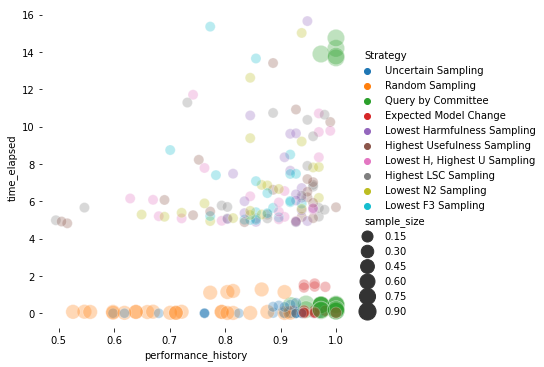

In [60]:
g = sns.relplot(
    data= df,
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=10), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

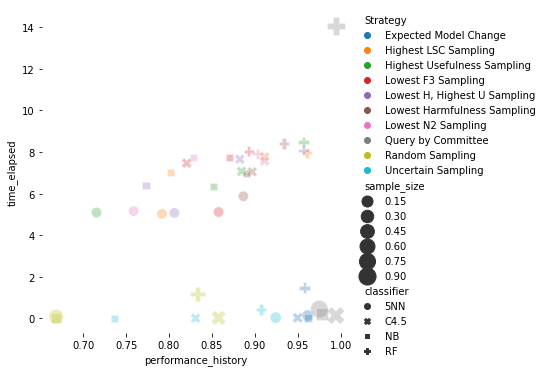

In [74]:
g = sns.relplot(
    data= performance_mean,
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size", style="classifier",
    palette=sns.color_palette(n_colors=10), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

In [ ]:
g = sns.relplot(
    data= df[(df.Strategy != "Uncertain Sampling") & (df.Strategy != "Query by Committee")],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=3), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

In [ ]:
g = sns.relplot(
    data= df[(df.Strategy == "Uncertain Sampling") | (df.Strategy == "Query by Committee")],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=2), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

## Baixando datasets

In [ ]:
from tqdm.notebook import tqdm, trange
p_bar = tqdm(datalist)
for dataset_id in p_bar:
    X_raw, y_raw, idx_data, dataset_name = which_oml_dataset(dataset_id)
    p_bar.set_description(f'"{dataset_name}"')

In [ ]:
ds = "1465_breast-tissue.arff"

X_raw, y_raw, idx_data, dataset_name = which_arff_dataset(ds)
   
from modAL.uncertainty import classifier_uncertainty

print(len(np.unique(y_raw)))
X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)), stratify = y_raw[idx_data[idx_bag][TRAIN]])
print(y_train)

learner = ActiveLearner (
    estimator= which_classifier(classifier), #cls,
    query_strategy=uncertainty_sampling,
    X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
)

uncertain_sample_score = learner.score(X_test, y_test)

total_of_samples = 1
while (total_of_samples != cost):

    #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)

    idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]

    if classifier_uncertainty(learner, X_train[0].reshape(1,-1)) > 0.2:
        #print("IF", learner.score(X_test, y_test))
        learner.teach(X_train, y_train)
        uncertain_sample_score = learner.score(X_test, y_test)
        performance_history.append(uncertain_sample_score)
    total_of_samples = total_of_samples + 1


In [ ]:
train_size= len(np.unique(y_raw)) + init_size